In [ ]:
# !pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/balanced_toxic_comments.csv')
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [ ]:
from tensorflow.keras.layers import TextVectorization
X = df['comment_text']
y = df[df.columns[2:]].values

In [ ]:
MAX_FEATURES = 200000
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')
vectorizer.adapt(X.values)


In [ ]:
vectorized_text = vectorizer(X.values)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [ ]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))
print('Train: ',int(len(train)))
print('Validation: ',int(len(val)))
print('Test: ',int(len(test)))

Train:  1871
Validation:  534
Test:  267


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [ ]:
model = Sequential()
# Create the embedding layer
model.add(Embedding(input_dim=MAX_FEATURES + 1, output_dim=32, input_length=1800))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer
model.add(Dense(6, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.build(input_shape=(None, 1800))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1800, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [ ]:
history = model.fit(train, epochs=5, validation_data=val,)

Epoch 1/5
1871/1871 [==============================] - 267s 140ms/step - loss: 0.2397 - accuracy: 0.9957 - val_loss: 0.1925 - val_accuracy: 0.9965
Epoch 2/5
1871/1871 [==============================] - 192s 103ms/step - loss: 0.1828 - accuracy: 0.9972 - val_loss: 0.1673 - val_accuracy: 0.9980
Epoch 3/5
1871/1871 [==============================] - 187s 100ms/step - loss: 0.1632 - accuracy: 0.9972 - val_loss: 0.1515 - val_accuracy: 0.9971
Epoch 4/5
1871/1871 [==============================] - 186s 99ms/step - loss: 0.1441 - accuracy: 0.9972 - val_loss: 0.1273 - val_accuracy: 0.9982
Epoch 5/5
1871/1871 [==============================] - 184s 98ms/step - loss: 0.1276 - accuracy: 0.9967 - val_loss: 0.1075 - val_accuracy: 0.9973


<Figure size 800x500 with 0 Axes>

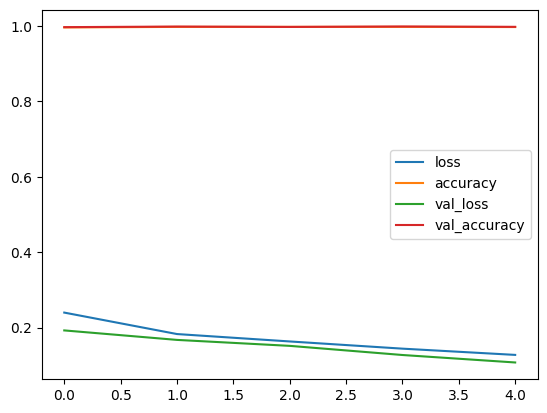

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

Model using AUC metic


In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.metrics import AUC

model = Sequential()
# Create the embedding layer with increased dimensions
model.add(Embedding(input_dim=MAX_FEATURES + 1, output_dim=100, input_length=1800))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='tanh')))
model.add(Dropout(0.5))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
# Final layer
model.add(Dense(6, activation='sigmoid'))

# Compile the model with AUC as a metric
optimizer = Adam(learning_rate=1e-4)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[AUC(name='auc')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

# Build the model
model.build(input_shape=(None, 1800))

# Train the model
history = model.fit(train, epochs=7, validation_data=val, callbacks=[early_stopping, reduce_lr])




Epoch 1/7
1871/1871 [==============================] - 447s 232ms/step - loss: 0.3243 - auc: 0.8737 - val_loss: 0.2211 - val_auc: 0.9496 - lr: 1.0000e-04
Epoch 2/7
1871/1871 [==============================] - 364s 194ms/step - loss: 0.2094 - auc: 0.9498 - val_loss: 0.1748 - val_auc: 0.9683 - lr: 1.0000e-04
Epoch 3/7
1871/1871 [==============================] - 356s 190ms/step - loss: 0.1839 - auc: 0.9623 - val_loss: 0.1641 - val_auc: 0.9709 - lr: 1.0000e-04
Epoch 4/7
1871/1871 [==============================] - 358s 192ms/step - loss: 0.1684 - auc: 0.9689 - val_loss: 0.1470 - val_auc: 0.9772 - lr: 1.0000e-04
Epoch 5/7
1871/1871 [==============================] - 352s 188ms/step - loss: 0.1542 - auc: 0.9739 - val_loss: 0.1412 - val_auc: 0.9796 - lr: 1.0000e-04
Epoch 6/7
1871/1871 [==============================] - 355s 190ms/step - loss: 0.1445 - auc: 0.9777 - val_loss: 0.1301 - val_auc: 0.9831 - lr: 1.0000e-04
Epoch 7/7
1871/1871 [==============================] - 352s 188ms/step - los

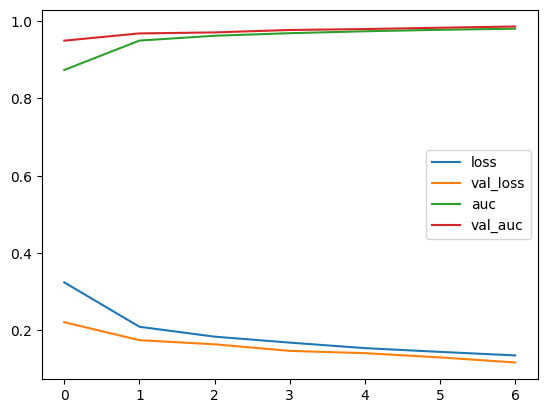

In [ ]:
# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['auc'], label='auc')
plt.plot(history.history['val_auc'], label='val_auc')
plt.legend()

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy, AUC
import numpy as np

# Initialize metrics
precision = Precision()
recall = Recall()
accuracy = CategoricalAccuracy()
auc = AUC()

# Evaluate the model on the test data
for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make a prediction
    yhat = model.predict(X_true)

    # Flatten the predictions and true labels
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    # Update metrics
    precision.update_state(y_true, yhat)
    recall.update_state(y_true, yhat)
    accuracy.update_state(y_true, yhat)
    auc.update_state(y_true, yhat)




1/1 [==============================] - 0s 90ms/step


In [ ]:
# Calculate and print the results
precision_result = precision.result().numpy()
recall_result = recall.result().numpy()
accuracy_result = accuracy.result().numpy()
auc_result = auc.result().numpy()

print(f"Precision: {precision_result:.4f}")
print(f"Recall: {recall_result:.4f}")
print(f"Accuracy: {accuracy_result:.4f}")
print(f"AUC: {auc_result:.4f}")

Precision: 0.8786
Recall: 0.8514
Accuracy: 0.1423
AUC: 0.9863


In [ ]:
input_text = ['You freaking suck! I am going to hit you.']
vectorized_input_text = vectorizer(tf.constant(input_text))

# Ensure the shape is correct (batch_size, sequence_length)
vectorized_input_text = tf.reshape(vectorized_input_text, (1, 1800))

# Make a prediction
res = model.predict(vectorized_input_text)
print(res)


1/1 [==============================] - 0s 127ms/step
[[0.99524987 0.22969869 0.94236964 0.05801576 0.7983274  0.19825074]]


In [ ]:
input_text = ['Can I ever hate you?']
vectorized_input_text = vectorizer(tf.constant(input_text))

# Ensure the shape is correct (batch_size, sequence_length)
vectorized_input_text = tf.reshape(vectorized_input_text, (1, 1800))

# Make a prediction
res = model.predict(vectorized_input_text)
print(res)


1/1 [==============================] - 0s 92ms/step
[[0.9242974  0.00108239 0.0812008  0.00772737 0.14097263 0.01760939]]


In [ ]:
input_text = ['You are a nice child']
vectorized_input_text = vectorizer(tf.constant(input_text))

# Ensure the shape is correct (batch_size, sequence_length)
vectorized_input_text = tf.reshape(vectorized_input_text, (1, 1800))

# Make a prediction
res = model.predict(vectorized_input_text)
print(res)

1/1 [==============================] - 0s 106ms/step
[[8.4142083e-01 5.7089084e-04 3.6748979e-02 7.9604322e-03 7.3253401e-02
  1.3302283e-02]]
